## Install Dependencies
In the previous notebook, all of our libraries were already installed for us because we selected the 'tensorflow' notebook image from the Jupyterhub spawner. However, when we run the model as part of an application we need to ensure we are packaging the model with the correct requirements. Take a look at the requirements.txt file to see which libraries we need for our application.

We can install these libraries into our environment:

In [7]:
import sys
!pip install -r requirements.txt
from ultralytics import YOLO
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Create a Predict Function
Extract the prediction logic into a standalone function called predict.

In [8]:
def detect_objects(carImage):
    
    model   = YOLO("models/best.pt")
    results = model.predict(carImage)
    result  = results[0]
   
    output  = []
    
    for box in result.boxes: 
      '''print("-----")
      print("box:  {}".format(box))
      print("-----")'''
      x1, y1, x2, y2 = [
          round(x) for x in box.xyxy[0].tolist()
      ]
      #class_id = result.names[box.cls[0].item()]
      class_id = box.cls[0].item()               #class id
      cords = box.xyxy[0].tolist()               #box coordinates (tensor)
      cords = [round(x) for x in cords]
      prob     = round(box.conf[0].item(), 2)    #confidence value
      output.append([
          x1, y1, x2, y2, result.names[class_id], prob
      ])     

    return output   #return array of array of attributes cords, class_id, probability


In [19]:
def display_image(image):
    fig = plt.figure(figsize=(10, 10))
    plt.grid(False)
    plt.imshow(image)
    
def draw_boxes(image, result_dict):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    class_colors = {}
    font = ImageFont.load_default()
    image_pil = Image.open(image)

    for d in result_dict:
        display_str = "{}: {}%".format(d['label'], int(100 * d['score']))
        print("display string is: ")
        print(display_str)
        if not class_colors.get(d['label']):
            class_colors[d['label']] = colors[hash(d['label']) % len(colors)]
        color = class_colors.get(d['label'])
        draw_bounding_box_on_image(
            image_pil,
            d['box']['yMin'],
            d['box']['xMin'],
            d['box']['yMax'],
            d['box']['xMax'],
            color,
            font,
            display_str_list=[display_str])
  
    return image_pil
    #image_pil.show()
    
    
def draw_bounding_box_on_image(image,
                           ymin,
                           xmin,
                           ymax,
                           xmax,
                           color,
                           font,
                           thickness=4,
                           display_str_list=()):

    """Adds a bounding box to an image."""
    print("drawing the image")
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    #(left, right, top, bottom) = (xmin * im_width, xmax * im_width,
    #                              ymin * im_height, ymax * im_height)
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)], width=thickness, fill=color)

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin


        
def create_dict(detections):
    result_dict = []
    max_boxes = 10
    num_detections = len(detections)
    print("num_detections: {}".format(num_detections))
    for i in range(0, num_detections):
        d = {
            'box': {
                'yMin': detections[i][0],
                'xMin': detections[i][1],
                'yMax': detections[i][2],
                'xMax': detections[i][3]
            },
            'label': detections[i][4],
            'score': detections[i][5],
        }
        result_dict.append(d)
   
    return result_dict

In [22]:
#obtain the image file
car_Image = "images/carImage1.jpg"
carImage  = Image.open(car_Image)

#call the detect_objects function to obtain dictionary of image cords, class_id and probability
detections = detect_objects(carImage)

#create array of dict
detection_dict = create_dict(detections)  
print('dict: {}'.format(detection_dict))


0: 448x640 1 severe, 208.0ms
Speed: 1.6ms preprocess, 208.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
num_detections: 1
dict: [{'box': {'yMin': 1, 'xMin': 22, 'yMax': 186, 'xMax': 218}, 'label': 'severe', 'score': 0.88}]


display string is: 
severe: 88%
drawing the image


/tmp/ipykernel_4313/3437884539.py:54: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
/tmp/ipykernel_4313/3437884539.py:62: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


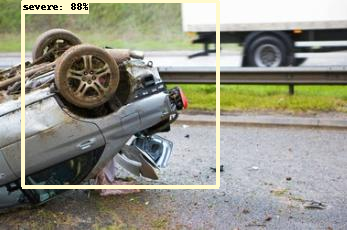

In [23]:
draw_boxes(car_Image, detection_dict)